# Original Data

## Load data

In [2]:
import numpy as np
import pandas as pd

In [3]:
# define a random state
random_state = 12014500

# set the random state
np.random.seed(random_state)

In [4]:
df_train = pd.read_json("./data2/trainset.json")
df_test = pd.read_json("./data2/testset.json")

ratio_features = ["age", "capital-gain", "capital-loss", "hours-per-week"]
ordinal_features = ["education-num"]
nominal_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
target = 'income'

## Train baseline

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

def create_model(categorical_features, random_state):
    categorical_features_onehot_transformer = ColumnTransformer(
        transformers=[
            ("one-hot-encoder", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ],
        remainder="passthrough",
    )

    model = Pipeline(
        [
            ("one-hot-encoder", categorical_features_onehot_transformer),
            ("clf", LogisticRegression(max_iter=1000, random_state=random_state)),
        ]
    )
    return model

def split_data(df, target, drop_na=False):
    _df = df.copy()
    if drop_na:
        _df = _df.dropna()
    
    X = _df.drop(columns=[target])
    y = _df[target]

    return X, y

def train_and_evaluate(model, df_train, df_test, target, drop_na = False, sample_weight = None):
    X_train, y_train = split_data(df_train, target, drop_na)
    X_test, y_test = split_data(df_test, target, drop_na)

    if sample_weight is not None:
        model.fit(X_train, y_train, clf__sample_weight=sample_weight)
    else:
        model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    return y_test, y_pred

def describe_model(y_test, y_pred):
    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='macro'),
        "Recall": recall_score(y_test, y_pred, average='macro'),
        "F1": f1_score(y_test, y_pred, average='macro')
    }

In [6]:
model = create_model(nominal_features, random_state)
y_test, y_pred = train_and_evaluate(model, df_train, df_test, target, drop_na=True)
metrics = describe_model(y_test, y_pred)
metrics

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'Accuracy': 0.8477056548552315,
 'Precision': 0.8009474218724006,
 'Recall': 0.7607582564719824,
 'F1': 0.777270198343837}

## Fairness Evaluation

In [6]:
X_train, y_train = split_data(df_train, target, drop_na=True)

model = create_model(nominal_features, random_state)
model.fit(X_train, y_train)
probs = pd.Series(model.predict_proba(X_train)[:, 1])

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [7]:
from aif360.detectors.mdss_detector import bias_scan

privileged_subset = bias_scan(
    data=X_train,
    observations=y_train,
    scoring="Bernoulli",
    expectations=probs,
    overpredicted=True,
    penalty=50,
    alpha=0.24,
    favorable_value=1,
)

unprivileged_subset = bias_scan(
    data=X_train,
    observations=y_train,
    scoring="Bernoulli",
    expectations=probs,
    overpredicted=False,
    penalty=50,
    alpha=0.24,
    favorable_value=1
)

In [8]:
print(privileged_subset)
print(unprivileged_subset)

({'capital-gain': [5013]}, 91.6241)
({'capital-loss': [1887]}, 21.0518)


In [9]:
import fairlens as fl

_df_train = df_train.copy()
_df_train.dropna(inplace=True)
_df_train.reset_index(inplace=True)

fscorer = fl.FairnessScorer(
    _df_train,
    target_attr="income",
    sensitive_attrs=privileged_subset[0].keys()
)

fscorer.demographic_report()

Sensitive Attributes: ['capital-gain']

Empty DataFrame
Columns: [Group, Distance, Proportion, Counts, P-Value]
Index: []

Weighted Mean Statistical Distance: nan


/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/fairlens/scorer.py:115: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['capital-gain [-0.00, 99999.00]', 'capital-gain [-0.00, 99999.00]', 'capital-gain [-0.00, 99999.00]', 'capital-gain [-0.00, 99999.00]', 'capital-gain [-0.00, 99999.00]', ..., 'capital-gain [-0.00, 99999.00]', 'capital-gain [-0.00, 99999.00]', 'capital-gain [-0.00, 99999.00]', 'capital-gain [-0.00, 99999.00]', 'capital-gain [-0.00, 99999.00]']
Length: 38309
Categories (1, object): ['capital-gain [-0.00, 99999.00]']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, attr] = utils._bin_as_string(col, distr_type.value, prefix=True)
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/fairlens/scorer.py:260: RuntimeWarning: invalid value encountered in scalar divide
  return (df_di

In [10]:
dff = X_train.copy()
dff["observed"] = y_train.copy()
dff["probabilities"] = probs.copy()

In [11]:
to_choose = dff[privileged_subset[0].keys()].isin(privileged_subset[0]).all(axis=1)
temp_df = dff.loc[to_choose]

"Our detected privileged group has a size of {}, we observe {} as the average probability of earning >50k, but our model predicts {}".format(
    len(temp_df),
    np.round(temp_df["observed"].mean(), 4),
    np.round(temp_df["probabilities"].mean(), 4),
)

'Our detected privileged group has a size of 96, we observe 0.0 as the average probability of earning >50k, but our model predicts 0.2798'

In [12]:
to_choose = dff[unprivileged_subset[0].keys()].isin(unprivileged_subset[0]).all(axis=1)
temp_df = dff.loc[to_choose]

"Our detected unprivileged group has a size of {}, we observe {} as the average probability of earning >50k, but our model predicts {}".format(
    len(temp_df),
    np.round(temp_df["observed"].mean(), 4),
    np.round(temp_df["probabilities"].mean(), 4),
)

'Our detected unprivileged group has a size of 192, we observe 1.0 as the average probability of earning >50k, but our model predicts 0.2193'

### Fairness Metrics

In [7]:
from aif360.sklearn.metrics import (
    equal_opportunity_difference,
    average_odds_difference,
    statistical_parity_difference,
    disparate_impact_ratio,
    theil_index,
)

def create_dataset(df, protected_attributes, priveleged_groups) -> pd.DataFrame:
    column_renaming = {}
    df = df.copy()  # Make a copy of the DataFrame to avoid modifying the original DataFrame

    for i, col in enumerate(protected_attributes):
        df[f"{col}_index"] = df[col].copy()
        df[f"{col}"] = df[col].map(lambda x: 1 if x in priveleged_groups[i] else 0)
        column_renaming[f"{col}_index"] = f"{col}"

    if len(protected_attributes) > 0:
        df.set_index(protected_attributes, inplace=True)
        df = df.rename(columns=column_renaming)

    return df


def calculate_fairness_metrics(
    observed, predictions, protected_attributes, priveleged_group
):
    fairness_metrics = {}

    fairness_metrics["statistical_parity_difference"] = statistical_parity_difference(
        observed,
        predictions,
        prot_attr=protected_attributes,
        priv_group=priveleged_group,
    )
    fairness_metrics["average_odds_difference"] = average_odds_difference(
        observed,
        predictions,
        prot_attr=protected_attributes,
        priv_group=priveleged_group,
    )
    fairness_metrics["equal_opportunity_difference"] = equal_opportunity_difference(
        observed,
        predictions,
        prot_attr=protected_attributes,
        priv_group=priveleged_group,
    )
    fairness_metrics["disparate_impact"] = disparate_impact_ratio(
        observed,
        predictions,
        prot_attr=protected_attributes,
        priv_group=priveleged_group,
    )
    fairness_metrics["theil_index"] = theil_index(1 + predictions - observed)

    return fairness_metrics

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/torch/_functorch/deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


In [15]:
df_train_bias = create_dataset(
    df_train.dropna(), list(privileged_subset[0].keys()), list(privileged_subset[0].values())
)
df_test_bias = create_dataset(
    df_test.dropna(), list(privileged_subset[0].keys()), list(privileged_subset[0].values())
)

In [16]:
model = create_model(nominal_features, random_state)
y_test, y_pred = train_and_evaluate(model, df_train, df_test, target, drop_na=True)
metrics = describe_model(y_test, y_pred)
metrics

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'Accuracy': 0.8477056548552315,
 'Precision': 0.8009474218724006,
 'Recall': 0.7607582564719824,
 'F1': 0.777270198343837}

In [17]:
model = create_model(nominal_features, random_state)
y_test, y_pred = train_and_evaluate(model, df_train, df_train, target, drop_na=True)
metrics = calculate_fairness_metrics(
    df_train_bias[target], y_pred, list(privileged_subset[0].keys()), (1,) * len(privileged_subset[0].keys())
)
metrics

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/skle

{'statistical_parity_difference': -0.6368818639381014,
 'average_odds_difference': -0.08331498691587386,
 'equal_opportunity_difference': 0.6004080756013745,
 'disparate_impact': 0.23574176327427837,
 'theil_index': 0.12170921644827831}

In [8]:
from aif360.detectors.mdss_detector import bias_scan


def iterate_it(df, model, penalty):
    X_train, y_train = split_data(df, target, drop_na=True)
    _, _ = train_and_evaluate(model, df, df, target, drop_na=True)
    y_probs = pd.Series(model.predict_proba(X_train)[:, 1])

    privileged_subset = bias_scan(
        data=X_train,
        observations=y_train,
        scoring="Bernoulli",
        expectations=y_probs,
        overpredicted=True,
        penalty=penalty,
        alpha=0.24,
        favorable_value=1,
    )

    df_bias = create_dataset(
        df.dropna(),
        list(privileged_subset[0].keys()),
        list(privileged_subset[0].values()),
    )

    if len(privileged_subset[0].keys()) == 0:
        return {
            "statistical_parity_difference": 0,
            "average_abs_odds_difference": 0,
            "equal_opportunity_difference": 0,
            "disparate_impact": 1,
            "theil_index": 0,
        }, privileged_subset
    else:
        metrics = calculate_fairness_metrics(
            df_bias[target],
            y_pred,
            list(privileged_subset[0].keys()),
            (1,) * len(privileged_subset[0].keys()),
        )
        return metrics, privileged_subset

In [24]:
df_bias = pd.DataFrame(
    columns=[
        "statistical_parity_difference",
        "average_abs_odds_difference",
        "equal_opportunity_difference",
        "disparate_impact",
        "theil_index",
    ]
)
priv_subsets = {}

for i in [1, 5, 25, 50, 100]:
    metrics, priv = iterate_it(df_train, model, i)    
    df_bias.loc[f"penalty_{i}"] = metrics.values()
    priv_subsets[f"penalty_{i}"] = priv

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/skle

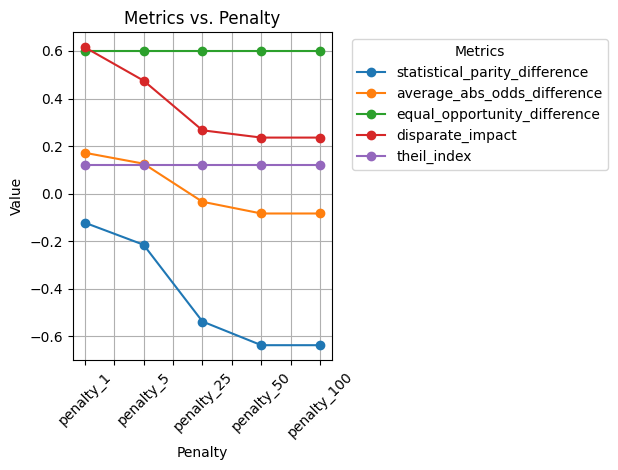

In [26]:
from matplotlib import pyplot as plt

df_bias.plot(kind="line", marker='o')
plt.xlabel("Penalty")
plt.ylabel("Value")
plt.title("Metrics vs. Penalty")
plt.legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

# Cleaned Original Data

## Prepare data

In [9]:
def clean_data(X: pd.DataFrame) -> pd.DataFrame:
    X = X.reset_index(drop=True)
    X = X.drop(columns=["fnlwgt", "education"], errors="ignore")
    cols = list(X.columns)
    X[cols] = X[cols].replace([" ?"], np.nan)
    X = X.dropna()
    def strip_str(x):
        if isinstance(x, str):
            return x.strip()
        else:
            return x
    X = X.map(strip_str)
    X["relationship"] = X["relationship"].replace(["Husband", "Wife"], "Married")
    X["hours-per-week"] = pd.cut(
        x=X["hours-per-week"],
        bins=[0.9, 25, 39, 40, 55, 100],
        labels=["PartTime", "MidTime", "FullTime", "OverTime", "BrainDrain"],
    )
    X.age = pd.qcut(X.age, q=5)
    X["capital-gain"] = pd.cut(
        x=X["capital-gain"],
        bins=[-1000000, 0, 1000, 10000, 100000, 1000000],
        labels=["None", "Little", "Medium", "High", "Very High"],
    )
    X["capital-loss"] = pd.cut(
        x=X["capital-loss"],
        bins=[-1000000, 0, 1000, 10000, 100000, 1000000],
        labels=["None", "Little", "Medium", "High", "Very High"],
    )
    return X

In [10]:
df_train_clean = clean_data(df_train)
df_test_clean = clean_data(df_test)

## Train baseline

In [11]:
model = create_model(df_train_clean.select_dtypes(include=["object", "category"]).columns.to_list(), random_state)
y_test, y_pred = train_and_evaluate(model, df_train_clean, df_test_clean, target, drop_na=True)
metrics = describe_model(y_test, y_pred)
metrics

{'Accuracy': 0.8488554405769834,
 'Precision': 0.8015657511734436,
 'Recall': 0.7649303196721635,
 'F1': 0.7802697028949117}

## Fairness Evaluation

In [12]:
X_train, y_train = split_data(df_train_clean, target, drop_na=True)

model = create_model(X_train.select_dtypes(include=["object", "category"]).columns.to_list(), random_state)
model.fit(X_train, y_train)
probs = pd.Series(model.predict_proba(X_train)[:, 1])

In [13]:
from aif360.detectors.mdss_detector import bias_scan

privileged_subset = bias_scan(
    data=X_train,
    observations=y_train,
    scoring="Bernoulli",
    expectations=probs,
    overpredicted=True,
    penalty=50,
    alpha=0.24,
    favorable_value=1,
)

unprivileged_subset = bias_scan(
    data=X_train,
    observations=y_train,
    scoring="Bernoulli",
    expectations=probs,
    overpredicted=False,
    penalty=50,
    alpha=0.24,
    favorable_value=1
)

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/aif360/detectors/mdss/MDSS.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in temp_df.groupby(column_name):
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/aif360/detectors/mdss/MDSS.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in temp_df.groupby(column_name):
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/aif360/detectors/mdss/MDSS.py:57: FutureWarning: The default of observed=False is deprecated a

In [14]:
print(privileged_subset)
print(unprivileged_subset)

({}, 0.0)
({}, 0.0)


In [16]:
import fairlens as fl

_df_train = df_train_clean.copy()
_df_train.dropna(inplace=True)
_df_train.reset_index(inplace=True)

fscorer = fl.FairnessScorer(
    _df_train,
    target_attr="income",
    sensitive_attrs=privileged_subset[0].keys()
)

if len(privileged_subset[0].keys()) > 0:
    fscorer.demographic_report()

No sensitive attributes detected. Fairness score will always be 0.


In [77]:
dff = X_train.copy()
dff["observed"] = y_train.copy()
dff["probabilities"] = probs.copy()

In [17]:
if len(privileged_subset[0].keys()) > 0:
    to_choose = dff[privileged_subset[0].keys()].isin(privileged_subset[0]).all(axis=1)
    temp_df = dff.loc[to_choose]

    "Our detected privileged group has a size of {}, we observe {} as the average probability of earning >50k, but our model predicts {}".format(
        len(temp_df),
        np.round(temp_df["observed"].mean(), 4),
        np.round(temp_df["probabilities"].mean(), 4),
    )

In [18]:
if len(privileged_subset[0].keys()) > 0:
    to_choose = dff[unprivileged_subset[0].keys()].isin(unprivileged_subset[0]).all(axis=1)
    temp_df = dff.loc[to_choose]

    "Our detected unprivileged group has a size of {}, we observe {} as the average probability of earning >50k, but our model predicts {}".format(
        len(temp_df),
        np.round(temp_df["observed"].mean(), 4),
        np.round(temp_df["probabilities"].mean(), 4),
    )

### Fairness Metrics

In [80]:
df_train_bias = create_dataset(
    df_train_clean.dropna(), list(privileged_subset[0].keys()), list(privileged_subset[0].values())
)
df_test_bias = create_dataset(
    df_test_clean.dropna(), list(privileged_subset[0].keys()), list(privileged_subset[0].values())
)

In [81]:
model = create_model(X_train.select_dtypes(include=["object", "category"]).columns.to_list(), random_state)
y_test, y_pred = train_and_evaluate(model, df_train_clean, df_test_clean, target, drop_na=True)
metrics = describe_model(y_test, y_pred)
metrics

{'Accuracy': 0.8488554405769834,
 'Precision': 0.8015657511734436,
 'Recall': 0.7649303196721635,
 'F1': 0.7802697028949117}

In [20]:
if len(privileged_subset[0].keys()) > 0:
    model = create_model(X_train.select_dtypes(include=["object", "category"]).columns.to_list(), random_state)
    y_test, y_pred = train_and_evaluate(model, df_train_clean, df_train_clean, target, drop_na=True)
    metrics = calculate_fairness_metrics(
        df_train_bias[target], y_pred, list(privileged_subset[0].keys()), (1,) * len(privileged_subset[0].keys())
    )
    metrics
else:
    print("Fair dataset")

Fair dataset


In [83]:
df_bias = pd.DataFrame(
    columns=[
        "statistical_parity_difference",
        "average_abs_odds_difference",
        "equal_opportunity_difference",
        "disparate_impact",
        "theil_index",
    ]
)
priv_subsets = {}
model = create_model(X_train.select_dtypes(include=["object", "category"]).columns.to_list(), random_state)

for i in [1, 5, 25, 50, 100]:
    metrics, priv = iterate_it(df_train_clean, model, i)    
    df_bias.loc[f"penalty_{i}"] = metrics.values()
    priv_subsets[f"penalty_{i}"] = priv

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/aif360/detectors/mdss/MDSS.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in temp_df.groupby(column_name):
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/aif360/detectors/mdss/MDSS.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in temp_df.groupby(column_name):
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/aif360/detectors/mdss/MDSS.py:57: FutureWarning: The default of observed=False is deprecated a

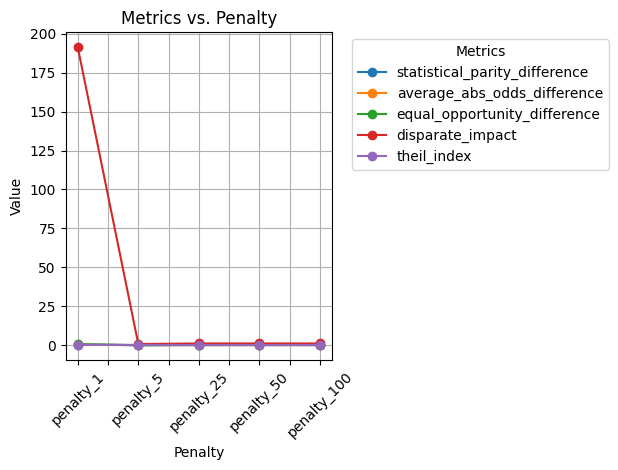

In [85]:
from matplotlib import pyplot as plt

df_bias.plot(kind="line", marker='o')
plt.xlabel("Penalty")
plt.ylabel("Value")
plt.title("Metrics vs. Penalty")
plt.legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()